# PredictiveGrid in Python
## A Quick Start Notebook

This notebook is a quick start to working with data using PredictiveGrid's Python API. It illustrates the basic, key functionality of the API to give you a running start working with data in the platform. 

The very first step is to import all the required packages. Below is a list of basic imports that you can copy and paste into your own notebooks to get going.
The external python libraries (```matplotlib```, ```numpy```, etc.) have wonderful, extensive documentation that you should look up if you want to explore all their functionalities or just unstick yourself. 
The ```%matplotlib inline``` command ensures that plots will be rendered in the notebook itself, rather than in a pop-up window. 

In [1]:
# PredictiveGrid imports
import btrdb # Platform Python bindings
from btrdb.utils import timez # helpful sub-package for handling time
from btrdb.stream import StreamSet # subpackage with light wrapper for working with multiple streams

# External Python libraries
import numpy as np # scientific computing package
import matplotlib.pyplot as plt # plotting package
import pandas as pd # data analysis library
from tabulate import tabulate # creating & printing neat tables
from datetime import datetime, timedelta # for working with time

%matplotlib inline

Next, we must connect to the database. The ```connect``` function optionally accepts endpoint and apikey string arguments, which can be passed like:

```btrdb.connect(endpoint_string, apikey=key_string) ```

When running a notebook on JupyterHub, these do not need to be passed. 

In [2]:
conn = btrdb.connect()
conn.info()

{'majorVersion': 5, 'build': '5.12.5', 'proxy': {'proxyEndpoints': []}}

## Find Collections
The streams in the database are organized into collections, which can be thought of as heirarchical paths such as ```CALIFORNIA/SanFrancisco/91405/Sensor1``` but are internally just strings. A single collection, defined by a path-like name, can contain any number of individual streams. It is best to name collections and organize streams into them in some logically consistent and descriptive way to facilitate searching (think about creating a file heirarchy to organize data files and mirror this in the collection name). 

Let us query and print out all collections in this cluster. We will print out the individual collection names to reflect the implicit heirarchical data organization they encode. 

In [3]:
collections = conn.list_collections()
print('Found', len(collections), 'collections')

collections.sort()

for i, c in enumerate(collections):
    levels = c.split('/')
    for j, l in enumerate(levels):
        if i == 0:
            pass
        elif l in collections[i-1]:
            continue
        print(j*' ','->', l)

Found 486 collections
 -> Health
  -> EKG
   -> patient001
 -> POW
  -> EPFL
  -> GridSweep
  -> signatures
   -> event0001
   -> event0004
   -> event0005
   -> event0007
   -> event0021
   -> event0022
   -> event0062
   -> event0064
   -> event0065
   -> event0067
   -> event0068
   -> event0207
   -> event0243
   -> event0245
   -> event0247
   -> event0249
   -> event0251
   -> event0253
   -> event0281
   -> event0283
   -> event0284
   -> event0287
   -> event0289
   -> event0306
   -> event0366
   -> event0550
   -> event0713
   -> event0715
   -> event0716
   -> event0719
   -> event0722
   -> event0723
   -> event0775
   -> event0779
   -> event0781
   -> event0782
   -> event0785
   -> event0788
   -> event0790
   -> event0793
   -> event0796
   -> event0799
   -> event0801
   -> event0803
   -> event0804
   -> event0807
   -> event0809
   -> event0811
   -> event0855
   -> event0857
   -> event0859
   -> event0868
   -> event0935
   -> event0940
   -> event0942
   -> event0

We can also limit the search to collections with a certain prefix (you may want to change the prefix below to obtain interesting results on your particular allocation). 

In [4]:
prefix = 'sunshine/PMU1'
collections = conn.list_collections(prefix)

print('Found', len(collections), 'collections')
print(collections)

Found 1 collections
['sunshine/PMU1']


## Find Streams
Now that we have a collection, the next step is to find individual streams (though we could have done this directly, if we know what we want). As you may recall, each stream represents a single time series within the database, which contains the atomic, ```(time, value)``` pairs, and has some associated metadata. 

To get the streams, we will use the ```streams_in_collection``` method. This takes an optional collection prefix argument. If we pass in no argument, we will get all streams in the database. Let us work with the collection we found previously. Note that the method returns an [iterator](https://wiki.python.org/moin/Iterator), which we convert to a list below. 

In [5]:
collection = collections[0]
streams = list(conn.streams_in_collection(collection))
print('Found', len(streams), 'streams in collection', collection)

Found 13 streams in collection sunshine/PMU1


Recall that streams have metadata, which can help us understand what the stream *is*. The convenience function below will obtain and pretilly print a set of streams and their metadata. 

In [6]:
def describe_streams(streams):
    table = [["Collection", "Name", "Units", "Version", "UUID"]]
    for stream in streams:
        # Get all the tags for this stream. 
        tags = stream.tags()
        table.append([
            stream.collection, stream.name, tags["unit"], stream.version(), stream.uuid
        ])
    return tabulate(table, headers="firstrow")

print(describe_streams(streams))

Collection     Name    Units      Version  UUID
-------------  ------  -------  ---------  ------------------------------------
sunshine/PMU1  LSTATE  mask        243640  6ffb2e7e-273c-4963-9143-b416923980b0
sunshine/PMU1  C1ANG   deg         240607  d625793b-721f-46e2-8b8c-18f882366eeb
sunshine/PMU1  C3MAG   amps        240481  fb61e4d1-3e17-48ee-bdf3-43c54b03d7c8
sunshine/PMU1  C2MAG   amps        240718  d765f128-4c00-4226-bacf-0de8ebb090b5
sunshine/PMU1  C1MAG   amps        240380  1187af71-2d54-49d4-9027-bae5d23c4bda
sunshine/PMU1  C3ANG   deg         240781  0be8a8f4-3b45-4fe3-b77c-1cbdadb92039
sunshine/PMU1  L3ANG   deg         240862  e4efd9f6-9932-49b6-9799-90815507aed0
sunshine/PMU1  L2ANG   deg         240662  886203ca-d3e8-4fca-90cc-c88dfd0283d4
sunshine/PMU1  L3MAG   volts       229263  b2936212-253e-488a-87f6-a9927042031f
sunshine/PMU1  L1ANG   deg         229265  51840b07-297a-42e5-a73a-290c0a47bddb
sunshine/PMU1  C2ANG   deg         229263  97de3802-d38d-403c-96af-d23b8

We can also search for streams in terms of their metadata tags, by passing an optional ```tag``` arguement to the same ```streams_in_collection``` method. Let us get all the streams with units of ```volts```.

In [7]:
streams = conn.streams_in_collection(collection, tags={"unit": "volts"})
print(describe_streams(streams))

Collection     Name    Units      Version  UUID
-------------  ------  -------  ---------  ------------------------------------
sunshine/PMU1  L3MAG   volts       229263  b2936212-253e-488a-87f6-a9927042031f
sunshine/PMU1  L1MAG   volts       229266  35bdb8dc-bf18-4523-85ca-8ebe384bd9b5
sunshine/PMU1  L2MAG   volts       229264  d4cfa9a6-e11a-4370-9eda-16e80773ce8c


The API also supports SQL queries to find streams and metadata, which you can learn more about in [this notebook](https://github.com/PingThingsIO/ni4ai-notebooks/blob/main/tutorials/7%20-%20Working%20with%20Metadata.ipynb). 

## Work with a stream
Let us work with the first stream in the above list of streams. We will look at its metadata and learn how to query time series data from the stream. 

In [8]:
stream = streams[0]
print(stream)

<Stream collection=sunshine/PMU1 name=L3MAG>


Let's checkout the stream's metadata. Note that ```stream.tags()``` returns a dictionary of tags, while ```stream.annotations``` returns a tuple, where the first element is the annotation version and the second is the dictionary of annotations. 

In [9]:
print('COLLECTION:', stream.collection)

print('\nTAGS:\n', stream.tags().keys())
print('\nANNOTATIONS:\n', stream.annotations()[0].keys(),)

COLLECTION: sunshine/PMU1

TAGS:
 dict_keys(['unit', 'ingress', 'distiller', 'name'])

ANNOTATIONS:
 dict_keys(['location', 'impedance'])


### Data Types from Time Series Queries

Before we move on, let's refresh some concepts on BTrDB data types.  

There are two data types (represented by Python objects) that we may obtain when querying time series data from a stream. These are: 

1. ```RawPoint```s --- RawPoints represent the atomic data type in a time series: a paired timestamp and value that is the raw data of the series. Recall that these are stored at the absolute bottom of the BTrDB tree.
2. ```StatPoint```s --- These are stored in the internal nodes of the BTrDB tree and contain precomputed statistical aggregates of the raw data that lies beneath them. 

Querying ```RawPoint```s will be slower than querying ```StatPoint```s. Between ```StatPoint```s, it is faster to query those that reside higher up in the tree, corresponding to longer durations of raw data and correspondingly larger numbers of ```RawPoint```s. 

### Data Time Range
There are a couple useful methods for understanding the time range covered by a stream. We can do this by getting the *earliest* and *latest* ```RawPoint```s in the stream, as shown below. 

A few things: queries for time series Points always return the Point(s) requested along with a ***version number***. For most introductory users, the version is not useful, though you can read more about it in our docs. Below, we discard the version and just work with the returned ```RawPoint```. 

Time stamps in BTrDB are integers which represent *nanoseconds since the Unix epoch* [(January 1, 1970)](https://www.epochconverter.com/). These can be easily converted to more readable time stamps using utility functions in the ```timez``` package [(read the docs here)](https://btrdb.readthedocs.io/en/latest/api/utils-timez.html).

In [10]:
# Get the earliest & latest RawPoints in the stream
earliest, version = stream.earliest()
latest, version = stream.latest()

# Get the time from the RawPoints
earliest_time = earliest.time
latest_time = latest.time

print('Stream starts at: ', timez.ns_to_datetime(earliest_time))
print('Stream ends at: ', timez.ns_to_datetime(latest_time))

Stream starts at:  2015-10-01 16:08:24.008333+00:00
Stream ends at:  2017-04-15 01:41:35.999999+00:00


### Querying Data
There are three different methods to query data from a stream. These are documented & described below (in order of increasing query speed). 
1. ```stream.values(start, end)```: This call will return all ```RawPoint```s in the stream between the ```start``` and ```end``` time.
2. ```stream.windows(start, end, width, depth=0)```: This call will return ```StatPoint```s spanning (and summarizing) windows of length ```width``` between the ```start``` and ```end``` times. The ```width```arguement is an integer specifying the window length in *nanoseconds*. The optional integer ```depth``` parameter trades off the precision of the window width for efficiency. It is specified as a power of $2$ in nanoseconds (so ```depth=30``` would make the windows accurate to roughly one second). 
3. ```stream.aligned_windows(start, end, pointwidth)```: Like ```stream.windows```, this call will return ```StatPoint```s corresponding to windows of a given width between the ```start``` and ```end``` times. However, this time, the width is specified as an integer power of $2$ in nanoseconds in the ```pointwidth``` argument. 

To reiterate, ```values``` returns ```RawPoint```s, while ```windows``` and ```aligned_windows``` return ```StatPoint```s. 

All these queries return a list of tuples, where each tuples contains a Point (```RawPoint``` or ```StatPoint```) and a version number. Further, as mentioned, the time stamps in the Points are in the inconvenient nanoseconds since the Unix epoch format. 

Overall, we need a function to convert this returned data into a more conducive format. We choose to convert the ```RawPoint```s to a [pandas Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html), and the ```StatPoint```s to a [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), which are easy to work with. The functions to do this are defined below (these can be easily modified to produce a ```numpy.array``` if desired). 

In [11]:
def rawpoints_to_series(rawpts_response):
    times, values = [], []
    for rawpoint, version in rawpts_response:
        times.append(timez.ns_to_datetime(rawpoint.time))
        values.append(rawpoint.value)
    return pd.Series(index=times, data=values)

def statpoints_to_dataframe(statpoints):
    attributes = ['min','mean','max','stddev','count','time',]
    
    df = pd.DataFrame([[getattr(p, attr) for attr in attributes] for p, version in statpoints],
                     columns=attributes)

    df['datetime'] = [timez.ns_to_datetime(t) for t in df['time']]
    return df.set_index('datetime')

#### ```stream.values```
Let us choose a ```start``` and ```end``` time for a ```values``` query. **CAUTION**: Most streams contain very high frequency data, so don't use too long a duration when querying raw data. 

In [12]:
start = datetime(2015, 10, 10)
end = start + timedelta(seconds=5)

In [13]:
# Query the data
rawpts_response = stream.values(start, end)
# Convert it to a pandas Series
data = rawpoints_to_series(rawpts_response)

It is very easy to plot the data in a pandas series. Just call ```plot()```! Here we pass a few aesthetic arguments to the call. 

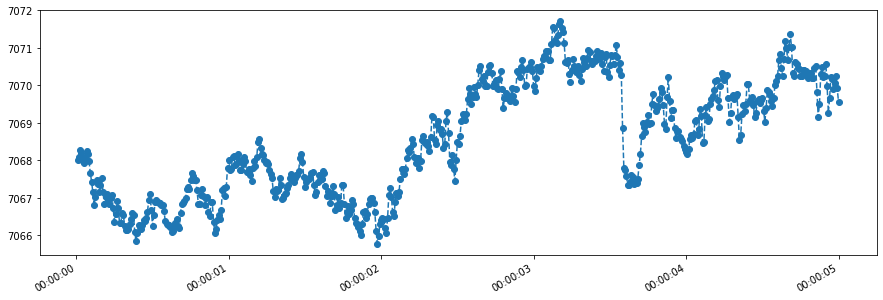

In [14]:
data.plot(linestyle='--', marker='o', figsize=(15, 5)); 

#### ```stream.windows```
Let us choose a longer time range and a window length for a ```windows``` query, which will return ```StatPoint```s. Remeber that the window width must be specified as an integer number of nanoseconds.  

In [15]:
start = datetime(2015, 10, 10)
end = start + timedelta(hours=24)
width = timedelta(minutes=1)
width_ns = int(1e9*width.seconds)

In [16]:
# Query the data
statpts_response = stream.windows(start, end, width_ns)
# Convert it to a pandas Series
data = statpoints_to_dataframe(statpts_response)

You can think of a pandas ```DataFrame``` as an excel file. In this case, the rows are timestamps (coressponding to the windows) and the columns contain the different aggregates. 

We can visualize the dataframe structure and entries with the ```head()``` call. 

In [17]:
data.head()

,min,mean,max,stddev,count,time
datetime,,,,,,
2015-10-10 00:00:00+00:00,7059.082520,7070.945893,7077.476562,2.470590,7200,1444435200000000000
2015-10-10 00:01:00+00:00,7043.672852,7058.894961,7069.110840,3.957179,7200,1444435260000000000
2015-10-10 00:02:00+00:00,7034.760254,7053.560129,7060.030762,4.170064,7200,1444435320000000000
2015-10-10 00:03:00+00:00,7041.854004,7053.804716,7058.428223,2.277033,7200,1444435380000000000
2015-10-10 00:04:00+00:00,7040.025879,7055.781075,7059.692383,1.901117,7200,1444435440000000000


Let us plot the resulting data. We can call ```.plot()``` on the ```DataFrame```, as we did earlier, but instead, we will manually plot only some of the columns, for easier and greater control of the visualization.  

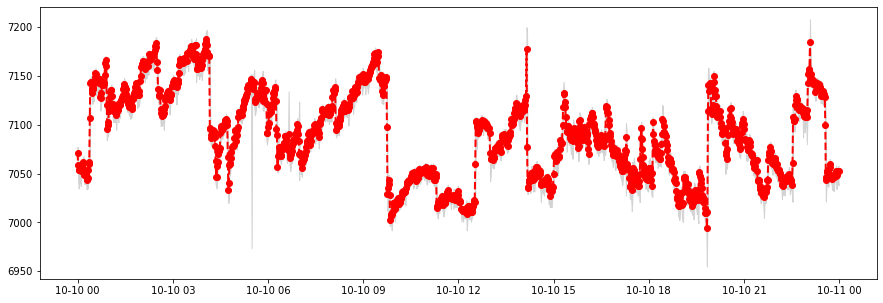

In [18]:
plt.figure(figsize=(15, 5))
# Plot the mean of the windows
plt.plot(data.index, data['mean'], linewidth=2, color='red', linestyle='--', marker='o')
# Show the range of the minimum and maximum over the windows
plt.fill_between(data.index, data['min'], data['max'], color='lightgrey')

#### ```stream.aligned_windows```
Let us use the same ```start``` and ```end``` times in an ```aligned_windows``` query. Now, however, the window width must be an integer power of $2$ nanoseconds, termed a ```pointwidth```. 
The following function will convert an arbitrary ```timedelta``` into the nearest pointwidth, and return the error (in seconds) between the input and returned widths. 

In [19]:
def to_nearest_pointwidth(dt):
    dt_ns = 1e9*dt.seconds
    prevpw = int(np.floor(np.log2(dt_ns)))
    nextpw = int(np.ceil(np.log2(dt_ns)))
    
    preverr = (dt_ns-(2**prevpw)) / 1e9
    nexterr = ((2**nextpw)-dt_ns) / 1e9
    
    if preverr <= nexterr:
        return prevpw, preverr
    else:
        return nextpw, nexterr
    
print(to_nearest_pointwidth(timedelta(seconds=1)))

(30, 0.073741824)


In [20]:
start = datetime(2015, 10, 10)
end = start + timedelta(hours=24)
width = timedelta(minutes=1)
pw, err = to_nearest_pointwidth(width)

print('pointwidth', pw, 'with error', err, 'seconds')

pointwidth 36 with error 8.719476736 seconds


In [21]:
# Query the data
statpts_response = stream.aligned_windows(start, end, pw)
# Convert it to a pandas Series
data = statpoints_to_dataframe(statpts_response)

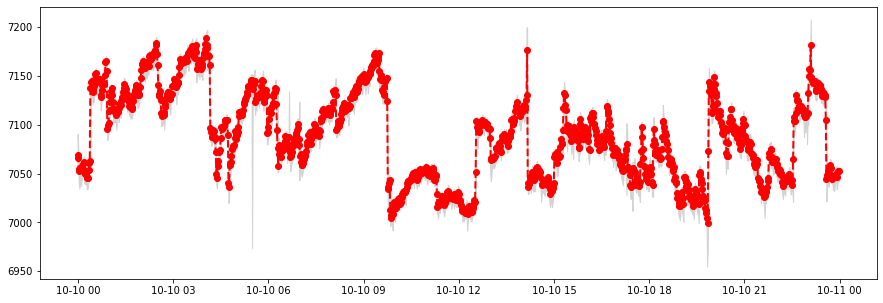

In [22]:
plt.figure(figsize=(15, 5))
# Plot the mean of the windows
plt.plot(data.index, data['mean'], linewidth=2, color='red', linestyle='--', marker='o')
# Show the range of the minimum and maximum over the windows
plt.fill_between(data.index, data['min'], data['max'], color='lightgrey')

What if we specify a longer window?

pointwidth 39 with error 50.244186112 seconds


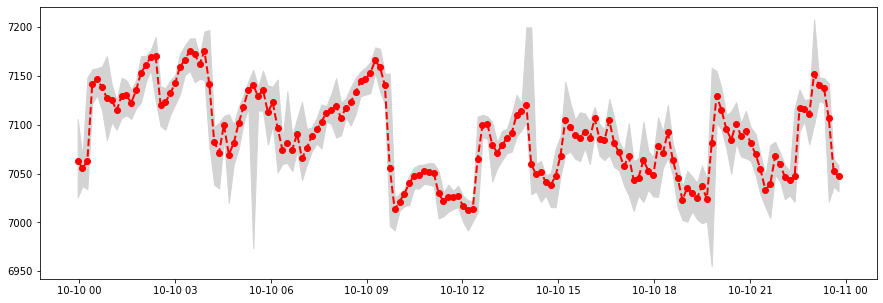

In [23]:
start = datetime(2015, 10, 10)
end = start + timedelta(hours=24)
width = timedelta(minutes=10)
pw, err = to_nearest_pointwidth(width)

print('pointwidth', pw, 'with error', err, 'seconds')

# Query the data
statpts_response = stream.aligned_windows(start, end, pw)
# Convert it to a pandas Series
data = statpoints_to_dataframe(statpts_response)

plt.figure(figsize=(15, 5))
# Plot the mean of the windows
plt.plot(data.index, data['mean'], linewidth=2, color='red', linestyle='--', marker='o')
# Show the range of the minimum and maximum over the windows
plt.fill_between(data.index, data['min'], data['max'], color='lightgrey');

## Work with multiple streams using streamsets
We often want to query data from a bunch of streams. Of course, we could do this manually by iterating through the individual streams and using the methods described. However, we also have the option of using a [```StreamSet```](https://btrdb.readthedocs.io/en/latest/working/streamsets.html), which is a light wrapper around a list of streams. 

The following cells show a few examples for working with ```StreamSet```s. For more, see [this notebook](https://github.com/PingThingsIO/ni4ai-notebooks/blob/main/tutorials/3%20-%20Working%20With%20StreamSets.ipynb). Notice that when querying ```StreamSet```s, version numbers are no longer returned, as they were for queries on single streams. 

To begin, we use the same collection as before, and get a list of streams, which we then convert to a ```StreamSet```. 

In [24]:
streams = conn.streams_in_collection(collection, tags={"unit": "volts"})
streamset = StreamSet(streams)

We can now do some queries on all streams at once. For example...

In [25]:
earliests = streamset.earliest() # Returns a list of RawPoints, one for each stream
latests = streamset.latest() # Returns a list of RawPoints, one for each stream

for i in range(len(streamset)):
    # Get the times for this stream
    earliest_time = earliests[i].time
    latest_time = latests[i].time
    print('Stream', streamset[i].name)
    print('starts at: ', timez.ns_to_datetime(earliest_time))
    print('ends at: ', timez.ns_to_datetime(latest_time))
    print('--------------------')

Stream L3MAG
starts at:  2015-10-01 16:08:24.008333+00:00
ends at:  2017-04-15 01:41:35.999999+00:00
--------------------
Stream L1MAG
starts at:  2015-10-01 16:08:24.008333+00:00
ends at:  2017-04-15 01:37:11.333333+00:00
--------------------
Stream L2MAG
starts at:  2015-10-01 16:08:24.008333+00:00
ends at:  2017-04-15 01:41:35.999999+00:00
--------------------


Let us make a ```values``` (ie raw data) query on this ```StreamSet```. Notice the difference in the query form: we use a function chaining approach to first set the ```start``` and ```end``` times. Then, the ```values``` are requested. 

In [26]:
start = datetime(2015, 10, 10)
end = start + timedelta(seconds=5)
data = streamset.filter(start, end).values()

The result ```data```, is a list of lists, each containing the ```RawPoint```s for one of the streams in the ```StreamSet```. 

To make the data more workable, we can instead query the result as a pandas ```DataFrame```, as shown below: 

In [27]:
data = streamset.filter(start, end).to_dataframe()

In [28]:
data.head()

,sunshine/PMU1/L3MAG,sunshine/PMU1/L1MAG,sunshine/PMU1/L2MAG
time,,,
1444435200008333000,7068.010742,7161.215332,7076.146484
1444435200016666000,7068.098633,7161.130371,7076.227539
1444435200024999000,7068.275879,7161.411133,7076.442383
1444435200033333000,7068.182617,7161.659668,7076.458984
1444435200041666000,7067.982422,7161.583008,7076.268066


The timestamps still need to be converted, which we do below: 

In [31]:
def to_human_time(time_ns):
    time_human = []
    for time in time_ns:
        time_human.append(timez.ns_to_datetime(time))
    return time_human

data.index = to_human_time(data.index)

In [32]:
data.head()

,sunshine/PMU1/L3MAG,sunshine/PMU1/L1MAG,sunshine/PMU1/L2MAG
2015-10-10 00:00:00.008333+00:00,7068.010742,7161.215332,7076.146484
2015-10-10 00:00:00.016666+00:00,7068.098633,7161.130371,7076.227539
2015-10-10 00:00:00.024999+00:00,7068.275879,7161.411133,7076.442383
2015-10-10 00:00:00.033333+00:00,7068.182617,7161.659668,7076.458984
2015-10-10 00:00:00.041666+00:00,7067.982422,7161.583008,7076.268066


And we can plot!

<AxesSubplot:>

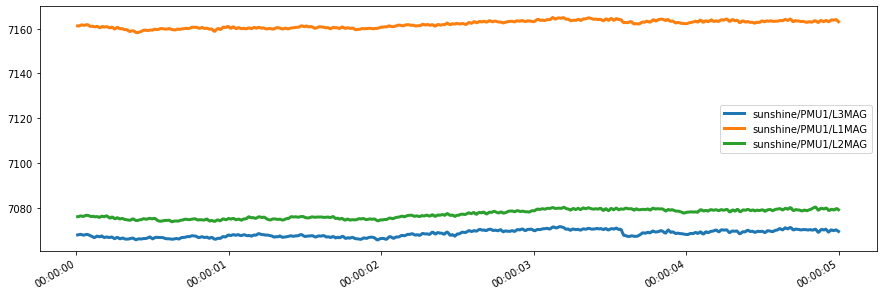

In [36]:
data.plot(figsize=(15, 5), linewidth=3)

And that is it! You've had a basic introduction to working with PredictiveGrid in Python. You are ready to start working with your data and conducting some interesting analyses.

As you go, you will want to learn about and use more advanced platform capabilities. Make sure to look at the notebooks [here](https://github.com/PingThingsIO/ni4ai-notebooks) containing both tutorials and analytics demos. You can also [read the blog](https://blog.ni4ai.org/), which shares user stories, capabilities, etc. Also, read the docs! 

# THE END #